In [1]:
import pandas as pd
from glob import glob
import uclchem
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.lines import Line2D

%matplotlib notebook
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
from cycler import cycler

In [2]:
%ls ../src/uclchem_tools/output_files

Reference.h5                v3.1.0-dev-h3tomolhydrogen.h5
v3.1.0-dev-h3tohydrogen.h5  v3.1.0.h5


In [3]:
path = "../src/uclchem_tools/output_files/"
dirs = glob(path + "*.h5")
dirs = [
    "../src/uclchem_tools/output_files/v3.1.0.h5",
    "../src/uclchem_tools/output_files/v3.1.0-dev-h3tomolhydrogen.h5",
]
names = [dir_.split("/")[-1] for dir_ in dirs]
dfs = {
    name: {key: pd.read_hdf(dir_, key) for key in ["phase1", "phase2", "static"]}
    for name, dir_ in zip(names, dirs)
}
dfs.keys()

dict_keys(['v3.1.0.h5', 'v3.1.0-dev-h3tomolhydrogen.h5'])

In [4]:
dfs["v3.1.0-dev-h3tomolhydrogen.h5"].keys()

dict_keys(['phase1', 'phase2', 'static'])

In [19]:
def plot_species(ax, df, species, **plot_kwargs):
    """Plot the abundance of a list of species through time directly onto an axis.

    Args:
        ax (pyplot.axis): An axis object to plot on
        df (pd.DataFrame): A dataframe created by `read_output_file`
        species (str): A list of species names to be plotted. If species name starts with "$" instead of # or @, plots the sum of surface and bulk abundances

    Returns:
        pyplot.axis: Modified input axis is returned
    """

    color_palette(n_colors=len(species))
    for specIndx, specName in enumerate(species):
        linestyle = "solid"
        if specName[0] == "$" and specName.replace("$", "#") in list(df.columns):
            abundances = df[specName.replace("$", "#")]
            linestyle = "dashdot"
            if specName.replace("$", "@") in df.columns:
                abundances = abundances + df[specName.replace("$", "@")]
        elif specName[0] == "#":
            linestyle = "dashed"
            abundances = df[specName]
        elif specName[0] == "@":
            linestyle = "dotted"
            abundances = df[specName]
        else:
            abundances = df[specName]
        if abundances.all() == 1e-30:
            addendum = " (np)"
        else:
            addendum = ""
        ax.plot(
            df["Time"],
            abundances,
            label=specName + addendum,
            lw=2,
            linestyle=linestyle,
            **plot_kwargs,
        )
    return ax


def plot_evolution(
    species_to_plot,
    runs_to_include,
    reference_run=None,
    verbose=False,
    plot_temp=False,
    fig=None,
    axes=None,
):
    i = 0
    print(plot_temp)
    if not fig and not axes:
        height_ratios = [1] * len(runs_to_include)
        if plot_temp:
            height_ratios += [0.5]
        fig, axes = plt.subplots(
            len(runs_to_include) + 1 if plot_temp else 0,
            3,
            figsize=(24, 15),
            height_ratios=height_ratios,
            tight_layout=True,
            sharex=True,
        )
    #     axes = axes.flatten()
    model_names = {
        "phase1": "Collapsing Cloud",
        "phase2": "Hot Core",
        "static": "Static Cloud",
    }
    model_data = {}
    for idx_i, df_key in enumerate(runs_to_include):
        df = dfs[df_key]
        print(df.keys())
        for idx_j, model in enumerate(["phase1", "phase2", "static"]):
            axis = axes[idx_i, idx_j]
            axis.set_prop_cycle(cycler(color=plt.get_cmap("tab10").colors))

            # Handle species that are not there.
            for spec in species_to_plot:
                if spec not in list(df[model].columns):
                    if spec.startswith("$"):
                        if not spec.replace("$", "#") in df[model]:
                            df[model][spec.replace("$", "#")] = 1.0e-30
                        if not spec.replace("$", "@") in df[model]:
                            df[model][spec.replace("$", "@")] = 1.0e-30

            if verbose:
                print(
                    f"Testing element conservation for {df_key} in {model}: {uclchem.analysis.check_element_conservation(df[model])}"
                )
            # plot species and save to test.png, alternatively send dens instead of time.

            axis = plot_species(axis, df[model], species_to_plot)
            if reference_run and df_key != reference_run:
                axis.set_prop_cycle(None)
                axis.set_prop_cycle(cycler(color=plt.get_cmap("tab10").colors))
                axis = plot_species(
                    axis, dfs[reference_run][model], species_to_plot, alpha=0.5
                )
            # plot species returns the axis so we can further edit
            axis.set(xscale="log", ylim=(1e-24, 1), xlim=(1e-6, 6e6), yscale="log")

            if model == "phase1":
                axis.set(xlim=(2e6, 6e6))
            axis.set_title(model_names[model])
            i = i + 1

            if plot_temp:
                axes[-1, idx_j].plot(
                    df[model]["Time"], df[model]["gasTemp"], label=model
                )
                axes[-1, idx_j].set(ylabel="Temperature (K)")
        if reference_run and df_key != reference_run:
            axis.legend(
                [Line2D([0], [0], c="black"), Line2D([0], [0], alpha=0.5)],
                [df_key, reference_run],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
            )
    axes[0, -1].legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    return fig, axes

In [20]:
speciesNames = [
    "H",
    "H2",
    "#H2",
    "$H",
    "H2O",
    "$H2O",
    # "CO",
    # "$CO",
    "$CH3OH",
    "CH3OH",
    "HE",
    "$HE",
]

In [21]:
speciesNames = [
    "HE",
    "@HE",
    "#HE",
]

In [22]:
speciesNames = [
    "H",
    "#H",
    "@H",
    "H2",
    "#H2",
    "@H2",
]

In [23]:
speciesNames = ["CO", "#CO", "@CO"]

In [24]:
from IPython.display import display
from ipywidgets import Checkbox, HBox, VBox, Box, Layout, Button, Output
import numpy as np

In [25]:
all_elements = [
    [df.columns.values for df in list(dfs.values())] for dfs in list(dfs.values())
]
unique_elements = []
for col1 in all_elements:
    for col2 in col1:
        for col3 in col2:
            if col3 not in unique_elements:
                if (
                    col3.startswith("#")
                    and col3.replace("#", "$") not in unique_elements
                ):
                    unique_elements.append(col3.replace("#", "$"))
                elif (
                    col3.startswith("@")
                    and col3.replace("@", "$") not in unique_elements
                ):
                    unique_elements.append(col3.replace("@", "$"))
                unique_elements.append(col3)

[
    unique_elements.remove(nonspecies)
    for nonspecies in ["Time", "Density", "gasTemp", "av", "zeta", "point", "radfield"]
]

[None, None, None, None, None, None, None]

In [26]:
unique_elements.sort(key=lambda x: x.replace("$", "").replace("@", "").replace("#", ""))

In [27]:
cols = 10
rows = len(unique_elements) // cols
try:
    boxes
except:
    boxes = [
        Checkbox(False, description=element, layout=Layout(max_width="175px"))
        for element in unique_elements
    ]
boxcontainer = []
for i in range(cols):
    rightbound = min(len(boxes), (i + 1) * rows)
    print(rightbound)
    boxcontainer.append(VBox(boxes[i * rows : rightbound]))
container = HBox(
    boxcontainer,
    layout=Layout(
        width="1920px",
        display="inline-flex",
    ),
)

41
82
123
164
205
246
287
328
369
410


In [28]:
render_button = Button(
    description="Make plots",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",
)


def on_change(a):
    global fig
    global axes
    print("hello world")
    species_to_plot = [b.description for b in boxes if b.value]
    if len(species_to_plot) == 0:
        print("Did not select enough species.")
    else:
        [ax.cla() for ax in axes.flatten()]
        fig, axes = plot_evolution(
            species_to_plot,
            list(dfs.keys()),
            list(dfs.keys())[0],
            verbose=False,
            fig=fig,
            axes=axes,
            plot_temp=True,
        )


render_button.on_click(on_change)

Button(description='Make plots', icon='check', style=ButtonStyle(), tooltip='Click me')

True


<IPython.core.display.Javascript object>


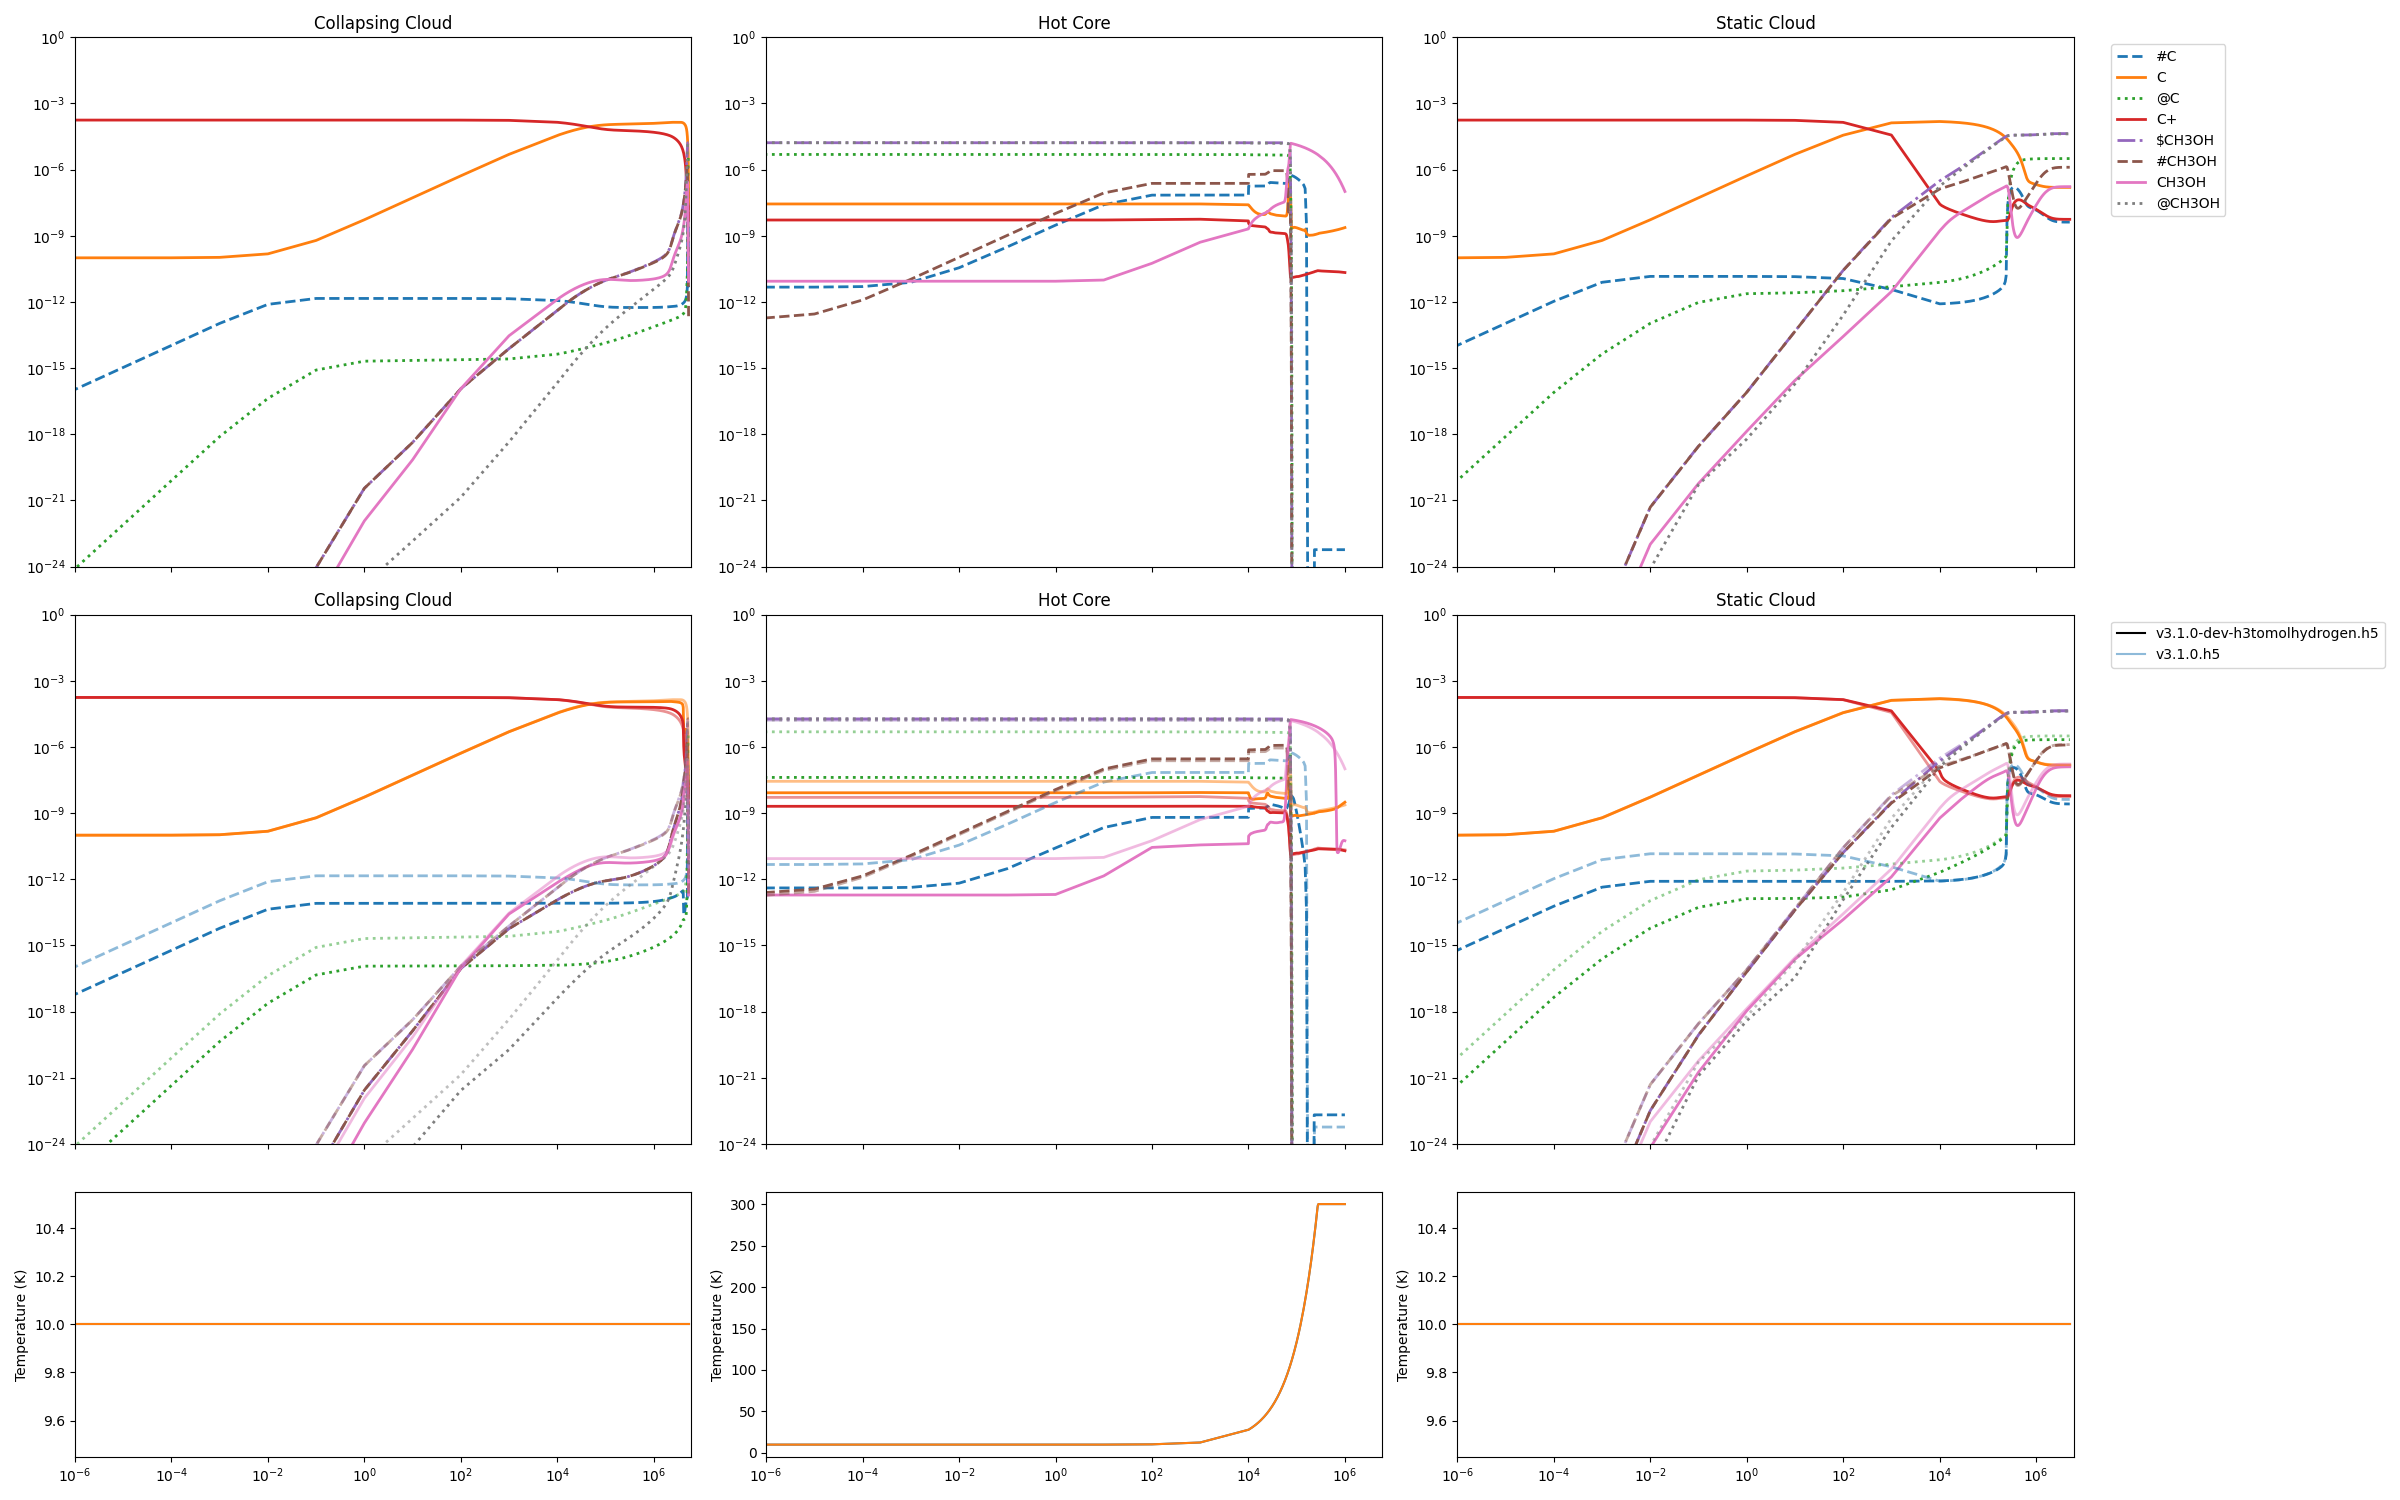

dict_keys(['phase1', 'phase2', 'static'])
dict_keys(['phase1', 'phase2', 'static'])


In [30]:
display(container)
display(render_button)
fig, axes = plot_evolution(
    [b.description for b in boxes if b.value],
    list(dfs.keys()),
    list(dfs.keys())[0],
    verbose=False,
    plot_temp=True,
)

In [16]:
del fig
del axes